Readme

This cell is just a helper to ensure the required Python libraries for this Notebook are installed in your Conda environment.

In [2]:
import sys
%conda install --yes --prefix {sys.prefix} -r requirements.txt

# This will reload the kernel with your new packages present, you may wish to run this yourself
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

usage: conda [-h] [-V] command ...
conda: error: unrecognized arguments: -r

Note: you may need to restart the kernel to use updated packages.


This cell generates some fake sales data for a few stores in different timezones
By default its 6 stores and about 21k rows
It also stores the computed opening hours for each store so you can easily track DST changes against transaction times
Feel free to modify the included stores and timezones, though note that later in this notebook we look at specific stores in the default list.

In [296]:
import random
# Note that we are using the dateutil package to handle timezones instead of pytz, as it is a bit easier in Python3
from datetime import datetime, timedelta
from dateutil import tz

# Define store locations and timezones
# We set specific open and close times rather than specifying the number hours open because net open hours can vary with daylight savings time
# and storing them as UTC offsets would be confusing to future code maintainers
stores = [
    {'name': 'New York', 'timezone': 'America/New_York', 'store_open_hour': 9, 'store_close_hour': 17},
    {'name': 'London', 'timezone': 'Europe/London', 'store_open_hour': 9, 'store_close_hour': 17},
    {'name': 'Madrid', 'timezone': 'Europe/Madrid', 'store_open_hour': 9, 'store_close_hour': 17},
    {'name': 'Tokyo', 'timezone': 'Asia/Tokyo', 'store_open_hour': 9, 'store_close_hour': 17},
    {'name': 'Auckland', 'timezone': 'Pacific/Auckland', 'store_open_hour': 9, 'store_close_hour': 17},
    {'name': 'Chatham', 'timezone': 'Pacific/Chatham', 'store_open_hour': 9, 'store_close_hour': 9},
]

# Define the mean and standard deviation for sales amounts in cents
# You could also use specific sale amounts to make validations easier, or some algorithm to generate sales amounts
min_sale_amount = 1500
mean_sale_amount = 10000
std_sale_amount = 5000
max_sale_amount = 25000

# Define the mean and standard deviation for the number of sales per day
# Again, you could also use specific sales counts to make validations easier, or some algorithm to generate sales counts
mean_sales_count = 150
std_sales_count = 25

# Declare the data structures we will use to store the data for output
sales_data = []
store_hours_data = []

for store in stores:
    store_sales = []
    store_hours = []
    store_timezone = tz.gettz(store['timezone'])
    
    # Here we instatiate the start DateTime for each store in the store's local timezone
    store_date = datetime(2023, 3, 20, 0, 0, 0 , 1, tzinfo=store_timezone)
    # We also declare that we should stop generating data when we reach midnight on the last day
    while store_date <= datetime(2023, 4, 5, 0, 0, 0, 0, tzinfo=store_timezone) + timedelta(microseconds=-1):
        # Define the store's open and close time for each day in the local timezone
        # We need to do this with each calendar day, as the local open and close times are set, but their relative position in UTC may shift with DST
        start_time_local = store_date.replace(hour=store['store_open_hour'], minute=0, second=0, microsecond=0)
        end_time_local = store_date.replace(hour=store['store_close_hour'], minute=0, second=0, microsecond=0) + timedelta(microseconds=-1)
        if store['store_close_hour'] <= store['store_open_hour']:
            # If the store close hour is less than or equal to the store open hour, it means the store closes the next calendar day
            # Remember that 1 day can have 23, 24, or 25 hours of elapsed store open time when converted to UTC because of DST changes
            end_time_local += timedelta(days=1)
        # Now we convert the local open and close times to UTC
        start_time_utc = start_time_local.astimezone(tz.UTC)
        end_time_utc = end_time_local.astimezone(tz.UTC)
        # We can also calculate how long the store is open - we use seconds here as the smallest resonable unit of time
        store_open_seconds = int((end_time_utc - start_time_utc).total_seconds())
        

        # write the store hours to the store_hours_data
        store_hours.append({
            'store': store['name'],
            'timezone': store['timezone'],
            'store_date': store_date.date().isoformat(),
            'store_open_seconds_elapsed': store_open_seconds,
            'store_open_timezone_offset': int(store_timezone.utcoffset(start_time_local).total_seconds()),
            'store_open_time_local': start_time_local.isoformat(),
            'store_close_time_local': end_time_local.isoformat(),
            'store_open_time_utc': start_time_utc.isoformat(),
            'store_close_time_utc': end_time_utc.isoformat(),
        })

        if store['name'] == 'Chatham':
            # Chatham is going to have a fixed sales count in order to show what happens when DST changes
            sales_count = 600
            # Generate sales uniformly across the day
            sale_times_seconds = [int(s * store_open_seconds / sales_count) for s in range(sales_count)]
        else:
            # Generate a random number of sales for the day based on a normal distribution
            sales_count = int(random.normalvariate(mean_sales_count, std_sales_count))
            # Generate sales randomly across the day as a list of offsets in seconds from the start of the day
            sale_times_seconds = [random.randint(1, store_open_seconds) for i in range(sales_count)]

        # Convert sale offsets into sale times
        sales_times_utc = [start_time_utc + timedelta(seconds=s) for s in sale_times_seconds]

        # Generate sales amounts for each sale time
        for sale_time_utc in sales_times_utc:
            if store['name'] == 'Chatham':
                # Chatham is going to have a fixed sales amount in order to easily show what happens when DST changes
                sale_amount = 50
            else:
                # Generate a random sale amount based on a normal distribution, rounded to the nearest cent
                sale_amount = round(random.normalvariate(mean_sale_amount, std_sale_amount))
                sale_amount = max(min_sale_amount, min(max_sale_amount, sale_amount))

            # Convert the sale time from the store's local timezone to UTC
            # This simulates a typical data pattern where the sale time is generated in a local timezone but stored in UTC for analysis
            sale_time_local= sale_time_utc.astimezone(store_timezone)

            # Add the sale to the store's sales data, include the local timestamp for easy validation during analysis
            store_sales.append({
                'store': store['name'],
                'timestamp_local': sale_time_local.isoformat(),
                'timestamp_utc': sale_time_utc.isoformat(),
                'sale_amount': sale_amount
            })

        # Increment the store's time by 1 day
        store_date += timedelta(days=1)

    # Add the store's sales data to the overall sales data
    sales_data.extend(store_sales)
    # Add the store's hours data to the overall hours data
    store_hours_data.extend(store_hours)


Here we pull both our new sample datasets into DataFrames and grab a quick sample to eyeball if the columns and values look correct.

In [297]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the sales data to a pandas dataframe
df = pd.DataFrame(sales_data)

# Set the timestamp_utc column as the index of the dataframe
df = df.set_index('timestamp_utc')

# Convert the index to a DatetimeIndex
df.index = pd.to_datetime(df.index)

df.sample()

,store,timestamp_local,sale_amount
timestamp_utc,,,
2023-04-04 05:48:07+00:00,Tokyo,2023-04-04T14:48:07+09:00,1500


In [298]:
dt = pd.DataFrame(store_hours_data)
dt.sample()

,store,timezone,store_date,store_open_seconds_elapsed,store_open_timezone_offset,store_open_time_local,store_close_time_local,store_open_time_utc,store_close_time_utc
38,Madrid,Europe/Madrid,2023-03-26,28799,7200,2023-03-26T09:00:00+02:00,2023-03-26T16:59:59.999999+02:00,2023-03-26T07:00:00+00:00,2023-03-26T14:59:59.999999+00:00


Now let's plot out each store to check the rough periodicity of the data.
We should see clear peaks as each store is only open for 8 out of 24 hours (except Chatham).
We should see that none of the periods directly overlap which shows they are correctly mapped to their local timezone.
Each line in the plot should start and end in slightly different places on the x axis to represent their local timezone offset against UTC.

Overall it is a very busy graph, so we'll dive into an individual store next to validate our generator is working as expected.

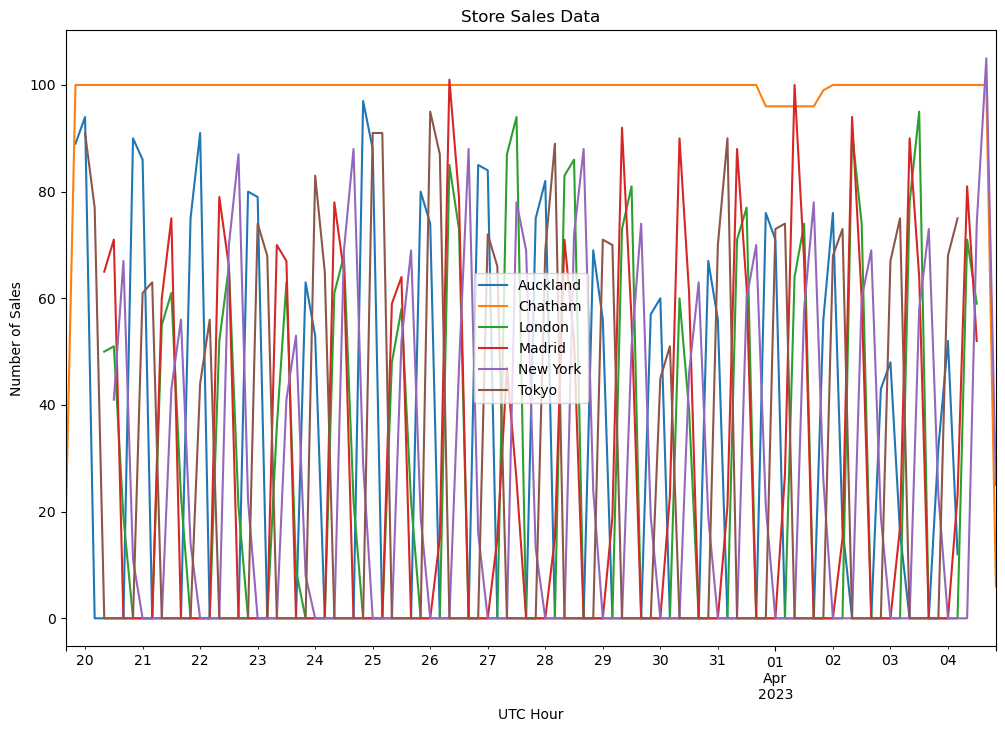

In [299]:
# Resample the sales data to hourly intervals
hourly_sales_4 = df.groupby('store').resample('4H').size().unstack(level=0)

# Plot the number of sales per hour for each store as a line chart
plt.figure(figsize=(12, 8))  # Set the size of the plot
for store in hourly_sales_4.columns:
    hourly_sales_4[store].plot(label=store)

# Format the plot
plt.xlabel('UTC Hour')
plt.ylabel('Number of Sales')
plt.title('Store Sales Data')
plt.legend()
plt.show()


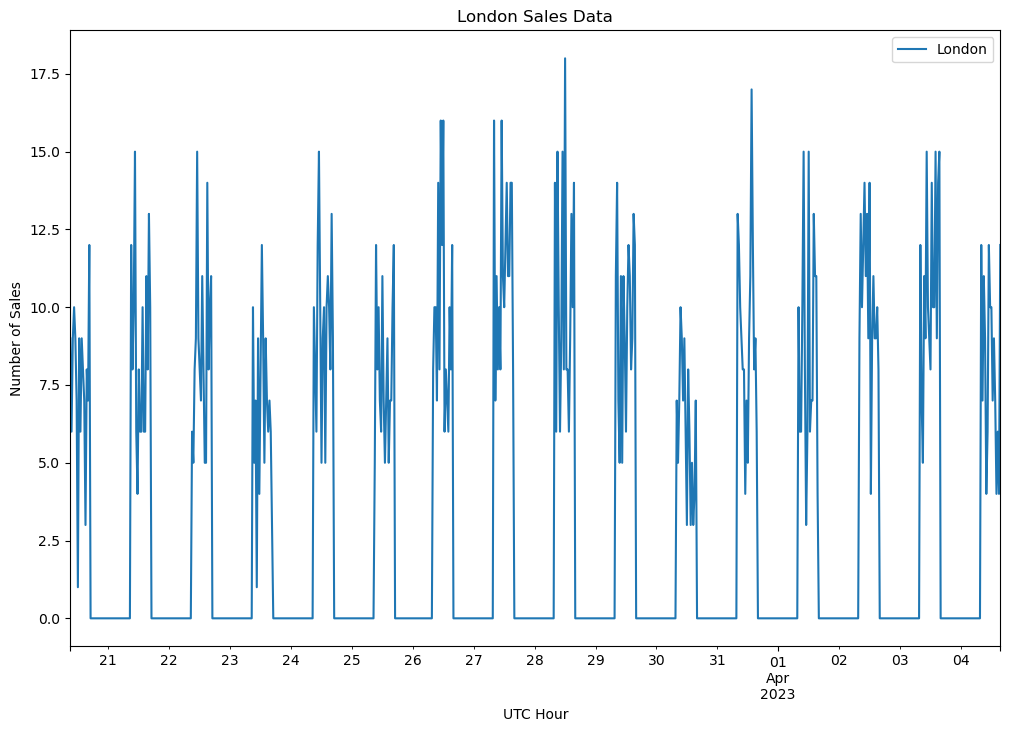

In [300]:
# Choose a single store to plot
store_name = 'London'

# Filter the sales data for the chosen store
london_store_sales = df[df['store'] == store_name]

# Resample the sales data to half hourly intervals
hourly_sales_30 = london_store_sales.resample('30Min').size()

# Plot the number of sales per hour for the chosen store as a line chart
plt.figure(figsize=(12, 8))
hourly_sales_30.plot(label=store_name)

# Format the plot
plt.xlabel('UTC Hour')
plt.ylabel('Number of Sales')
plt.title(f'{store_name} Sales Data')
plt.legend()
plt.show()


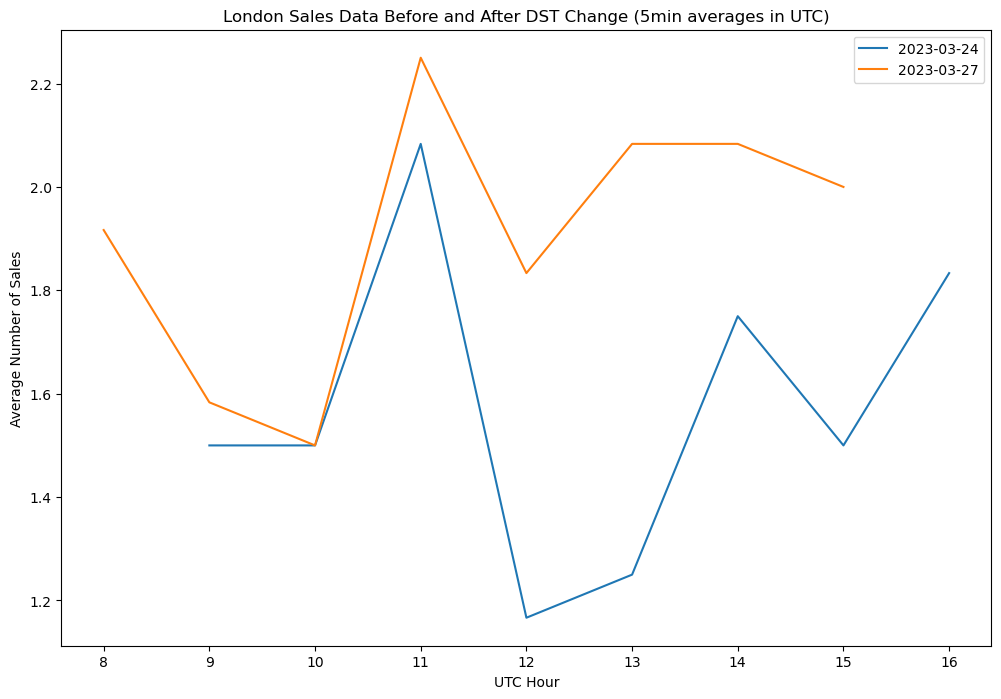

In [301]:
# Choose the days before and after the DST change
day_before_dst = '2023-03-24'
day_after_dst = '2023-03-27'

# Filter the sales data for the chosen days
london_day_before_sales = london_store_sales[(london_store_sales.index.date == pd.to_datetime(day_before_dst).date())]
london_day_after_sales = london_store_sales[(london_store_sales.index.date == pd.to_datetime(day_after_dst).date())]

# Resample the sales data to hourly intervals
sales_before_5m = london_day_before_sales.resample('5Min').size()
sales_after_5m = london_day_after_sales.resample('5Min').size()

# Calculate the mean sales per hour across the selected period
mean_sales_before = sales_before_5m.groupby(sales_before_5m.index.hour).mean()
mean_sales_after = sales_after_5m.groupby(sales_after_5m.index.hour).mean()

# Plot the normalized number of sales per hour for the chosen store and days as a line chart
plt.figure(figsize=(12, 8))
mean_sales_before.plot(label=day_before_dst)
mean_sales_after.plot(label=day_after_dst)

# Format the plot
plt.xlabel('UTC Hour')
plt.ylabel('Average Number of Sales')
plt.title(f'London Sales Data Before and After DST Change (5min averages in UTC)')
plt.legend()
plt.show()


Now let's do a specific check on our DST change.
We have a high number of randomly generated sales throughout the business day, so we should expect to see a sale reasonably soon after the store opens each day, and just before closing.
Taking the day before the DST change, and the day after the DST change, and examining the UTC timestamps of these events relative to each other, we should see that there is almost exactly a 1hr offset for the London store's sales.

In [302]:
store_name = 'London'
day_before_dst = '2023-03-24'
day_after_dst = '2023-03-27'

opening_time_before = [x for x in store_hours_data if x['store'] == store_name and x['store_date'] == day_before_dst][0]['store_open_time_utc']
first_sale_utc_before = london_day_before_sales.index.min()
last_sale_utc_before = london_day_before_sales.index.max()
closing_time_before = [x for x in store_hours_data if x['store'] == store_name and x['store_date'] == day_before_dst][0]['store_close_time_utc']

opening_time_after = [x for x in store_hours_data if x['store'] == store_name and x['store_date'] == day_after_dst][0]['store_open_time_utc']
first_sale_utc_after = london_day_after_sales.index.min()
last_sale_utc_after = london_day_after_sales.index.max()
closing_time_after = [x for x in store_hours_data if x['store'] == store_name and x['store_date'] == day_after_dst][0]['store_close_time_utc']


print(f"{store_name} opening time on {day_before_dst}: {opening_time_before}")
print(f"Time of first sale in {store_name} on {day_before_dst}: {first_sale_utc_before}")
print(f"Time of last sale in {store_name} on {day_before_dst}: {last_sale_utc_before}")
print(f"{store_name} closing time on {day_before_dst}: {closing_time_before}")
print("\n")
print(f"{store_name} opening time on {day_after_dst}: {opening_time_after}")
print(f"Time of first sale in {store_name} on {day_after_dst}: {first_sale_utc_after}")
print(f"Time of last sale in {store_name} on {day_after_dst}: {last_sale_utc_after}")
print(f"{store_name} closing time on {day_after_dst}: {closing_time_after}")

London opening time on 2023-03-24: 2023-03-24T09:00:00+00:00
Time of first sale in London on 2023-03-24: 2023-03-24 09:00:15+00:00
Time of last sale in London on 2023-03-24: 2023-03-24 16:59:45+00:00
London closing time on 2023-03-24: 2023-03-24T16:59:59.999999+00:00


London opening time on 2023-03-27: 2023-03-27T08:00:00+00:00
Time of first sale in London on 2023-03-27: 2023-03-27 08:01:49+00:00
Time of last sale in London on 2023-03-27: 2023-03-27 15:52:59+00:00
London closing time on 2023-03-27: 2023-03-27T15:59:59.999999+00:00


Now let's look at a more complex case - Auckland's business day splits across the UTC midnight boundary.
For any given calendar day, your UTC timestamps are going to start a few hours before midnight, and finish a few hours after.
Then add in the DST change, and have a look below.

In [303]:
auckland_store_name = 'Auckland'
auckland_day_before_dst = '2023-04-01'
auckland_day_after_dst = '2023-04-03'

opening_time_before = [x for x in store_hours_data if x['store'] == auckland_store_name and x['store_date'] == auckland_day_before_dst][0]['store_open_time_utc']
closing_time_before = [x for x in store_hours_data if x['store'] == auckland_store_name and x['store_date'] == auckland_day_before_dst][0]['store_close_time_utc']

opening_time_after = [x for x in store_hours_data if x['store'] == auckland_store_name and x['store_date'] == auckland_day_after_dst][0]['store_open_time_utc']
closing_time_after = [x for x in store_hours_data if x['store'] == auckland_store_name and x['store_date'] == auckland_day_after_dst][0]['store_close_time_utc']


print(f"{auckland_store_name} opening time on {auckland_day_before_dst}: {opening_time_before}")
print(f"{auckland_store_name} closing time on {auckland_day_before_dst}: {closing_time_before}")
print("\n")
print(f"{auckland_store_name} opening time on {auckland_day_after_dst}: {opening_time_after}")
print(f"{auckland_store_name} closing time on {auckland_day_after_dst}: {closing_time_after}")

Auckland opening time on 2023-04-01: 2023-03-31T20:00:00+00:00
Auckland closing time on 2023-04-01: 2023-04-01T03:59:59.999999+00:00


Auckland opening time on 2023-04-03: 2023-04-02T21:00:00+00:00
Auckland closing time on 2023-04-03: 2023-04-03T04:59:59.999999+00:00


Now let's look at a very complex example.
Let's say we have a store in the Chatham Island which records the start of the new business day at 0900 each day instead of 0000 (midnight) due to some local regulations.
Let us also say that this store remains open 24hrs a day, and we are recording sales through a DST change.

The Chatham Islands DST change back one hour at 0345 local time on April 2nd.
This is during the April 1st store business day (open at 0900 Apr1, close at 0859 Apr2)

However, when viewed in UTC this is at 2015 on April 1st and the day has 25hrs elapsed, which may confuse an inexperienced developer.
You can also see that the offset changes from +1345 to +1245 on Apr1 - this is what trips up naive addSeconds timezone conversions twice a year.
In addition to this, the Chatham Islands timezone has a 15min offset which looks a lot like a typo when it changes from 49500 to 45900.
It is also a timezone where almost nobody has a store as the local population is only 800 people.
This is what makes it an excellent timezone for test data.

In [304]:
chatham_store_name = 'Chatham'
for this_day in ['2023-03-31', '2023-04-01', '2023-04-02']:
    this_days_info = [x for x in store_hours_data if x['store'] == chatham_store_name and x['store_date'] == this_day][0]

    print(f"{chatham_store_name} store date: {this_day}")
    print(f"opening time UTC: {this_days_info['store_open_time_utc']}")
    print(f"opening time local: {this_days_info['store_open_time_local']}")
    print(f"timezone offset at store open: {this_days_info['store_open_timezone_offset']}")
    print(f"hours open: {round(this_days_info['store_open_seconds_elapsed'] /60 /60)}")
    print(f"closing time UTC: {this_days_info['store_close_time_utc']}")
    print(f"closing time local: {this_days_info['store_close_time_local']}")
    print("\n")

Chatham store date: 2023-03-31
opening time UTC: 2023-03-30T19:15:00+00:00
opening time local: 2023-03-31T09:00:00+13:45
timezone offset at store open: 49500
hours open: 24
closing time UTC: 2023-03-31T19:14:59.999999+00:00
closing time local: 2023-04-01T08:59:59.999999+13:45


Chatham store date: 2023-04-01
opening time UTC: 2023-03-31T19:15:00+00:00
opening time local: 2023-04-01T09:00:00+13:45
timezone offset at store open: 49500
hours open: 25
closing time UTC: 2023-04-01T20:14:59.999999+00:00
closing time local: 2023-04-02T08:59:59.999999+12:45


Chatham store date: 2023-04-02
opening time UTC: 2023-04-01T20:15:00+00:00
opening time local: 2023-04-02T09:00:00+12:45
timezone offset at store open: 45900
hours open: 24
closing time UTC: 2023-04-02T20:14:59.999999+00:00
closing time local: 2023-04-03T08:59:59.999999+12:45




Finally, satisfied that our data is representative of the situation we are examining, we output it as ndjson ready for import to Tinybird!

In [305]:
import json

# Open the output file
with open('datasources/fixtures/sales_data_raw.ndjson', 'w') as f:
    # Write each sale as a JSON object on a new line
    for sale in sales_data:
        f.write(json.dumps(sale) + '\n')

with open('datasources/fixtures/store_hours_raw.ndjson', 'w') as f:
    # Write each sale as a JSON object on a new line
    for store_day in store_hours_data:
        f.write(json.dumps(store_day) + '\n')